In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.pyplot import figure
import matplotlib
import numpy as np
from scipy.special import sph_harm as spherical
from scipy.special import lpmv as legendre
from scipy.signal import savgol_filter
import glob
from scipy.signal import correlate
#from scipy.signal import correlation_lags
from scipy.ndimage import correlate as incorrelate
from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
import pickle
import astropy.constants as const
from scipy import integrate
#import PyAstronomy 

c = 2.99e8
pi = np.pi
loc0 = '/data/bleblanc/MastersMESA/Jupiter/0Me_core/summary/'

In [13]:
m0core_J_l0 = np.genfromtxt(loc0 + 'summary_l0_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l1 = np.genfromtxt(loc0 + 'summary_l1_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l2 = np.genfromtxt(loc0 + 'summary_l2_nocoreJupiter.txt',usecols=(2),skip_header=6)
m0core_J_l3 = np.genfromtxt(loc0 + 'summary_l3_nocoreJupiter.txt',usecols=(2),skip_header=6)

In [14]:
print(m0core_J_l0[0])

1.352093796923835


In [15]:
# Set the max for the hemispheral grid
ymax = 2*pi; ymin = 0; xmax = pi; xmin = 0
numsamp = 100 # grid resolution

# Generate grid
phi = np.linspace(xmin,xmax,numsamp)
theta = np.linspace(ymin,ymax,numsamp)
grid_phi, grid_theta = np.meshgrid(phi,theta)

# Set the amplitude of the expected radial velocity
velamp = 1 #m/s

# Spherical order and degree
degree = [0,1,2,3]
order = np.arange(-3,4,1)
#order = [0]
# Centre of hemisphere
cen = np.random.rand()*2*pi
print('Hemisphere = ', cen-pi, cen+pi)

# Time series
night = 8*3600 # seconds/night
time = np.arange(0, night, 30) # 30 seconds for each SPIRou observation

vel = []
velocity = np.empty(len(time))

sine = np.empty((1,25,len(time)))
series = np.empty((1,25,len(time)))
# the time series of spherical harmonics: for a given a,b there is a sine wave
# for a given time i there is a disk projection
t_sph = np.empty((numsamp,numsamp,len(time)))

Hemisphere =  -0.9895242468548484 5.293661060324737


In [16]:
for l in range(len(degree)):
    for m in range(len(order)):
        if abs(order[m]) <= degree[l]:
            if degree[l] == 0:
                f = m0core_J_l0
            elif degree[l] == 1:
                f = m0core_J_l1
            elif degree[l] == 2:
                f = m0core_J_l2
            elif degree[l] == 3:
                f = m0core_J_l3
            
            # make phase offset array
            offset = np.linspace(0,2*pi,num = len(f))
            
            # for each frequency dependent on n
            for n in range(len(f)):               
                # Determine time series
                # where f is in uHz from GYRE 
                
                # add array of phase offsets = # freq
                w = 2*pi*f[n]
                sf = np.sin(w*time+offset[n])
                
                # in the time series
                for i in range(len(sf)):
                    sph_n = spherical(order[m], degree[l], grid_theta, grid_phi).real
                
                    # Normalize for simplicity
                    sphmax = np.max(sph_n)
                    #sphmin = np.min(sph)
                    sph_n = sph_n/sphmax

                    sph_n *= sf[i]
                    # in the grid 
                    
                    for a in range(numsamp):
                        for b in range(numsamp):
                            phi_len = phi[a] - pi/2
                            theta_len = np.min([abs(theta[b] - cen),abs(theta[b] - 2*pi)])
                            
                            # 2pi periodicity next try
                            #if theta_len > 2*pi:
                            #    theta_len -= 2*pi
                            
                            # length of the projected r vector
                            r = np.sqrt(phi_len**2 + theta_len**2)

                            # periodicity
                            if r > pi:
                                r = 2*pi - r
                            
                            # project on the plane
                            if r < pi/2 and r < 2*pi:
                                sph_n[a,b] = sph_n[a,b]*np.cos(r)
                            # 2pi periodicity first try
                            elif r > 2*pi:
                                sph_n[a,b] = sph_n[a,b]*np.cos(r) - 2*pi
                            else:
                                sph_n[a,b] = 0
                            # When the above is commented out, the full hemisphere is plotted
                            
                           
                            t_sph[a,b,i] +=sph_n[a,b]
                            
                # Average the velocity over the visible hemisphere
                    velocity[i] = np.sum(t_sph[:,:,i]/(numsamp**2/2))
                
            vel.append(velocity)
            
            print('Observed Velocity = ', velocity, 'm = ', order[m], 'l = ', degree[l])

Observed Velocity =  [-2.30013739e-16 -3.01587509e-02 -2.46208134e+00  1.53870629e+00
  2.63051928e+00 -8.53943408e-01  2.80426476e+00 -2.54832604e-01
  2.33968536e+00  1.11990364e-01  8.97974617e-02  8.07645696e-01
 -2.68999790e+00  6.10566631e-01 -1.49957593e+00 -3.44891056e+00
  9.02717729e-01  2.81171454e-01  2.53228048e-01 -1.16621940e+00
  1.65765579e+00 -1.53875181e+00 -4.53105769e-01 -1.28211898e+00
  9.15204865e-01 -9.06034141e-01  3.20972635e+00 -1.03508005e-01
  4.24076647e-01  1.58699460e-01  1.44071266e+00  5.76707317e-01
 -1.85966148e+00  5.20106578e+00 -7.26760018e-01  1.04687200e+00
 -1.09589441e-01 -2.11552491e+00 -1.62728082e+00 -2.56227496e+00
 -1.89401168e+00 -2.36840918e+00 -1.10887757e+00  1.44329024e+00
 -5.81829596e-01 -4.79998004e-01  4.06868306e+00  1.41486446e+00
  1.20227176e+00  1.52779157e+00  8.01894681e-01 -1.26261876e+00
 -4.19618358e-01 -1.11094240e+00 -1.15315180e+00  1.01649280e+00
  1.60546535e+00  3.84892802e-01 -9.85040969e-01  1.37183198e+00
 -6.

Observed Velocity =  [-1.71340441e-16 -2.95687124e-01 -2.08110958e+00  2.05828116e+00
  2.04755142e+00 -1.31605152e+00  2.59423655e+00  6.66055835e-01
  1.91432956e+00  1.26515719e-01  1.62605410e-01  6.55914067e-01
 -2.52588831e+00  9.62151717e-01 -1.33182562e+00 -3.98676350e+00
  1.36979145e+00  6.47745133e-01  1.48298886e-01 -8.69602287e-01
  1.80296955e+00 -1.97587176e+00 -6.13481528e-01 -9.13328566e-01
  9.82103642e-01 -8.14706510e-01  3.13202679e+00 -7.61320162e-01
  1.43249652e+00 -3.12368076e-01  9.54515850e-01  2.60774578e-01
 -2.35806633e+00  5.04391382e+00 -7.32975136e-01  1.15791626e+00
 -9.27377066e-01 -2.29843220e+00 -1.35260524e+00 -2.95072465e+00
 -2.89676482e+00 -2.12858215e+00 -1.53828279e+00  9.74413100e-01
 -7.28228284e-01  4.86993735e-02  3.67467659e+00  9.44945460e-01
  1.64548719e+00  1.07757408e+00  6.56460937e-01 -8.47562129e-01
 -6.30869219e-01 -1.44191202e+00 -6.44348016e-01  1.25366654e+00
  1.50354385e+00  3.46298524e-01 -1.29270421e+00  1.75428260e+00
 -3.

Observed Velocity =  [-1.57221867e-16 -3.23282296e-01 -2.04151689e+00  2.11227824e+00
  1.98696619e+00 -1.36407634e+00  2.57240926e+00  7.61759638e-01
  1.87012424e+00  1.28025274e-01  1.70172013e-01  6.40145279e-01
 -2.50883313e+00  9.98690378e-01 -1.31439208e+00 -4.04266014e+00
  1.41833233e+00  6.85841490e-01  1.37394069e-01 -8.38776202e-01
  1.81807136e+00 -2.02129968e+00 -6.30148661e-01 -8.75001833e-01
  9.89056132e-01 -8.05215239e-01  3.12395182e+00 -8.29683628e-01
  1.53729707e+00 -3.61324011e-01  9.03987597e-01  2.27941106e-01
 -2.40986331e+00  5.02758172e+00 -7.33621045e-01  1.16945659e+00
 -1.01236606e+00 -2.31744093e+00 -1.32405943e+00 -2.99109448e+00
 -3.00097646e+00 -2.10365800e+00 -1.58290895e+00  9.25684803e-01
 -7.43442843e-01  1.03644520e-01  3.63372927e+00  8.96108887e-01
  1.69154858e+00  1.03078499e+00  6.41346661e-01 -8.04427156e-01
 -6.52823573e-01 -1.47630820e+00 -5.91470322e-01  1.27831495e+00
  1.49295161e+00  3.42287594e-01 -1.32467827e+00  1.79402898e+00
 -2.

Observed Velocity =  [-2.23850094e-16 -5.76201737e-02 -2.42268055e+00  1.59244166e+00
  2.57022769e+00 -9.01735461e-01  2.78254327e+00 -1.59592662e-01
  2.29569430e+00  1.13492602e-01  9.73273909e-02  7.91953337e-01
 -2.67302539e+00  6.46928194e-01 -1.48222689e+00 -3.50453628e+00
  9.51023335e-01  3.19083164e-01  2.42376085e-01 -1.13554272e+00
  1.67268440e+00 -1.58395955e+00 -4.69692119e-01 -1.24397801e+00
  9.22123657e-01 -8.96588873e-01  3.20169052e+00 -1.71540123e-01
  5.28369248e-01  1.09980806e-01  1.39042931e+00  5.44032984e-01
 -1.91120740e+00  5.18481285e+00 -7.27402796e-01  1.05835640e+00
 -1.94166511e-01 -2.13444151e+00 -1.59887338e+00 -2.60244913e+00
 -1.99771822e+00 -2.34360583e+00 -1.15328743e+00  1.39479812e+00
 -5.96970412e-01 -4.25319169e-01  4.02793420e+00  1.36626459e+00
  1.24810990e+00  1.48122926e+00  7.86853661e-01 -1.21969285e+00
 -4.41466303e-01 -1.14517188e+00 -1.10053039e+00  1.04102174e+00
  1.59492445e+00  3.80901313e-01 -1.01686006e+00  1.41138572e+00
 -6.

Observed Velocity =  [-2.25003685e-16 -3.29517269e-02 -2.40685986e+00  1.62617426e+00
  2.62599736e+00 -8.93347952e-01  2.76810155e+00 -8.71036942e-02
  2.23864605e+00  1.39745767e-01  3.15793812e-02  7.85281785e-01
 -2.70801279e+00  5.83810389e-01 -1.45414464e+00 -3.48956734e+00
  9.13489948e-01  3.23182840e-01  2.83864343e-01 -1.11666525e+00
  1.67941147e+00 -1.60336584e+00 -4.50309380e-01 -1.22741103e+00
  8.97802214e-01 -8.45526064e-01  3.20830379e+00 -2.07988915e-01
  5.33682863e-01  1.27894743e-01  1.35998028e+00  4.82803258e-01
 -1.99254398e+00  5.16111148e+00 -7.73554732e-01  9.69598625e-01
 -1.93986694e-01 -2.18967033e+00 -1.61399383e+00 -2.62528103e+00
 -1.95901211e+00 -2.37678988e+00 -1.16911866e+00  1.35892573e+00
 -5.62188274e-01 -4.34532167e-01  4.00745590e+00  1.37067398e+00
  1.24996725e+00  1.48390468e+00  8.06522410e-01 -1.23158472e+00
 -4.60077775e-01 -1.22064823e+00 -1.08688580e+00  9.85900425e-01
  1.59677356e+00  3.03895419e-01 -1.01862822e+00  1.42765001e+00
 -6.

Observed Velocity =  [-2.02948899e-16  7.15385419e-02 -2.33984679e+00  1.76905836e+00
  2.86222575e+00 -8.57820255e-01  2.70692954e+00  2.19944084e-01
  1.99700183e+00  2.50948564e-01 -2.46915138e-01  7.57022518e-01
 -2.85621191e+00  3.16456852e-01 -1.33519420e+00 -3.42616211e+00
  7.54506540e-01  3.40548189e-01  4.59599741e-01 -1.03670434e+00
  1.70790587e+00 -1.68556674e+00 -3.68208241e-01 -1.15723683e+00
  7.94781776e-01 -6.29234916e-01  3.23631619e+00 -3.62378207e-01
  5.56190200e-01  2.03774352e-01  1.23100466e+00  2.23447223e-01
 -2.33706835e+00  5.06071756e+00 -9.69044468e-01  5.93639666e-01
 -1.93225032e-01 -2.42360781e+00 -1.67804082e+00 -2.72199207e+00
 -1.79506132e+00 -2.51735042e+00 -1.23617635e+00  1.20697794e+00
 -4.14858573e-01 -4.73556462e-01  3.92071422e+00  1.38935118e+00
  1.25783463e+00  1.49523720e+00  8.89835029e-01 -1.28195612e+00
 -5.38911992e-01 -1.54034995e+00 -1.02909023e+00  7.52418323e-01
  1.60460601e+00 -2.22850905e-02 -1.02611781e+00  1.49654207e+00
 -4.

Observed Velocity =  [-2.62378053e-16 -1.69187944e-01 -2.49423266e+00  1.43987951e+00
  2.31799870e+00 -9.39669576e-01  2.84785868e+00 -4.87437891e-01
  2.55370595e+00 -5.24235953e-03  3.94685344e-01  8.22126707e-01
 -2.51478821e+00  9.32390547e-01 -1.60923426e+00 -3.57223617e+00
  1.12077526e+00  3.00541598e-01  5.47374965e-02 -1.22091968e+00
  1.64225997e+00 -1.49619088e+00 -5.57354263e-01 -1.31890535e+00
  1.03212204e+00 -1.12753020e+00  3.17178074e+00 -6.69348965e-03
  5.04337407e-01  2.89615992e-02  1.52814091e+00  8.20956135e-01
 -1.54334717e+00  5.29200680e+00 -5.18671838e-01  1.45978041e+00
 -1.94979763e-01 -1.88465861e+00 -1.53048825e+00 -2.49918749e+00
 -2.17277398e+00 -2.19352462e+00 -1.08168768e+00  1.55703787e+00
 -7.54279283e-01 -3.83651618e-01  4.12055121e+00  1.34632231e+00
  1.23970964e+00  1.46912916e+00  6.97897979e-01 -1.16590961e+00
 -3.57292361e-01 -8.03815611e-01 -1.16224067e+00  1.29031842e+00
  1.58656147e+00  7.29175200e-01 -1.00886318e+00  1.33782735e+00
 -7.

Observed Velocity =  [-2.89015732e-16 -2.73678213e-01 -2.56124573e+00  1.29699542e+00
  2.08177031e+00 -9.75197273e-01  2.90903069e+00 -7.94485669e-01
  2.79535017e+00 -1.16445156e-01  6.73179863e-01  8.50385975e-01
 -2.36658909e+00  1.19974408e+00 -1.72818470e+00 -3.63564140e+00
  1.27975867e+00  2.83176250e-01 -1.20997901e-01 -1.30088059e+00
  1.61376557e+00 -1.41398997e+00 -6.39455402e-01 -1.38907955e+00
  1.13514248e+00 -1.34382134e+00  3.14376834e+00  1.47695802e-01
  4.81830070e-01 -4.69180092e-02  1.65711653e+00  1.08031217e+00
 -1.19882280e+00  5.39240072e+00 -3.23182101e-01  1.83573937e+00
 -1.95741426e-01 -1.65072114e+00 -1.46644126e+00 -2.40247644e+00
 -2.33672476e+00 -2.05296408e+00 -1.01462999e+00  1.70898565e+00
 -9.01608985e-01 -3.44627324e-01  4.20729290e+00  1.32764510e+00
  1.23184226e+00  1.45779665e+00  6.14585360e-01 -1.11553821e+00
 -2.78458144e-01 -4.84113892e-01 -1.22003624e+00  1.52380052e+00
  1.57872902e+00  1.05535571e+00 -1.00137359e+00  1.26893529e+00
 -9.

Observed Velocity =  [-2.87773985e-16 -2.49009766e-01 -2.54542503e+00  1.33072802e+00
  2.13753998e+00 -9.66809764e-01  2.89458898e+00 -7.21996701e-01
  2.73830191e+00 -9.01919911e-02  6.07431854e-01  8.43714423e-01
 -2.40157648e+00  1.13662628e+00 -1.70010244e+00 -3.62067246e+00
  1.24222528e+00  2.87275925e-01 -7.95096427e-02 -1.28200312e+00
  1.62049263e+00 -1.43339627e+00 -6.20072664e-01 -1.37251257e+00
  1.11082103e+00 -1.29275854e+00  3.15038161e+00  1.11247011e-01
  4.87143685e-01 -2.90040723e-02  1.62666749e+00  1.01908244e+00
 -1.28015938e+00  5.36869936e+00 -3.69334037e-01  1.74698160e+00
 -1.95561610e-01 -1.70594996e+00 -1.48156171e+00 -2.42530834e+00
 -2.29801866e+00 -2.08614813e+00 -1.03046122e+00  1.67311326e+00
 -8.66826847e-01 -3.53840323e-01  4.18681460e+00  1.33205449e+00
  1.23369962e+00  1.46047207e+00  6.34254109e-01 -1.12743007e+00
 -2.97069616e-01 -5.59590249e-01 -1.20639165e+00  1.46867921e+00
  1.58057813e+00  9.78349816e-01 -1.00314176e+00  1.28519958e+00
 -9.

Observed Velocity =  [-2.84470991e-16 -2.59549461e-01 -2.54590043e+00  1.31903776e+00
  2.15686107e+00 -9.77945194e-01  2.88080943e+00 -7.46245508e-01
  2.73998627e+00 -7.09698180e-02  6.12261502e-01  8.37906165e-01
 -2.39912737e+00  1.14465030e+00 -1.70303160e+00 -3.61615457e+00
  1.23606491e+00  2.94177070e-01 -7.51557045e-02 -1.27708094e+00
  1.63070897e+00 -1.44330623e+00 -6.22575671e-01 -1.36200391e+00
  1.12860502e+00 -1.31216214e+00  3.14157850e+00  1.00094558e-01
  5.14372247e-01 -3.61496484e-02  1.61281245e+00  1.00939228e+00
 -1.26873415e+00  5.36882784e+00 -3.65727872e-01  1.74786594e+00
 -1.93692767e-01 -1.69912865e+00 -1.49507846e+00 -2.42356550e+00
 -2.31970119e+00 -2.09563364e+00 -1.03232885e+00  1.69046152e+00
 -8.82022580e-01 -3.57007487e-01  4.18510984e+00  1.36428261e+00
  1.24996005e+00  1.45972086e+00  6.38375180e-01 -1.11400773e+00
 -2.99422425e-01 -5.66209352e-01 -1.21297621e+00  1.46836135e+00
  1.58225717e+00  9.66743225e-01 -1.01169913e+00  1.28415166e+00
 -9.

Observed Velocity =  [-2.78872299e-16 -3.04937215e-01 -2.54794764e+00  1.26869525e+00
  2.24006469e+00 -1.02589840e+00  2.82146972e+00 -8.50669678e-01
  2.74723974e+00  1.18078387e-02  6.33059719e-01  8.12893695e-01
 -2.38858062e+00  1.17920466e+00 -1.71564561e+00 -3.59669891e+00
  1.20953611e+00  3.23895906e-01 -5.64060656e-02 -1.25588425e+00
  1.67470425e+00 -1.48598212e+00 -6.33354529e-01 -1.31674985e+00
  1.20518932e+00 -1.39572109e+00  3.10366910e+00  5.20680455e-02
  6.31628324e-01 -6.69210936e-02  1.55314760e+00  9.67662936e-01
 -1.21953293e+00  5.36938113e+00 -3.50198414e-01  1.75167427e+00
 -1.85644854e-01 -1.66975363e+00 -1.55328654e+00 -2.41606016e+00
 -2.41307406e+00 -2.13648168e+00 -1.04037158e+00  1.76516942e+00
 -9.47460925e-01 -3.70646445e-01  4.17776853e+00  1.50306859e+00
  1.31998337e+00  1.45648586e+00  6.56122007e-01 -1.05620624e+00
 -3.09554473e-01 -5.94713614e-01 -1.24133171e+00  1.46699254e+00
  1.58948769e+00  9.16761027e-01 -1.04855024e+00  1.27963895e+00
 -9.

Observed Velocity =  [-2.48003342e-16 -4.78456767e-01 -2.55577422e+00  1.07623344e+00
  2.55815614e+00 -1.20922579e+00  2.59461115e+00 -1.24988827e+00
  2.77497010e+00  3.28270778e-01  7.12572301e-01  7.17269828e-01
 -2.34825987e+00  1.31130764e+00 -1.76386957e+00 -3.52231896e+00
  1.10811525e+00  4.37512436e-01  1.52747001e-02 -1.17484828e+00
  1.84290028e+00 -1.64913408e+00 -6.74562618e-01 -1.14374139e+00
  1.49797476e+00 -1.71517097e+00  2.95873967e+00 -1.31539607e-01
  1.07990391e+00 -1.84561800e-01  1.32504604e+00  8.08129649e-01
 -1.03143435e+00  5.37149639e+00 -2.90828557e-01  1.76623368e+00
 -1.54877294e-01 -1.55745152e+00 -1.77581879e+00 -2.38736691e+00
 -2.77004297e+00 -2.29264570e+00 -1.07111932e+00  2.05078130e+00
 -1.19763484e+00 -4.22788833e-01  4.14970235e+00  2.03365404e+00
  1.58768587e+00  1.44411831e+00  7.23968977e-01 -8.35228397e-01
 -3.48289776e-01 -7.03686769e-01 -1.34973612e+00  1.46175950e+00
  1.61713034e+00  7.25676697e-01 -1.18943383e+00  1.26238663e+00
 -1.

Observed Velocity =  [-1.57150473e-16 -1.07033878e+00 -2.58247100e+00  4.19738634e-01
  3.64317857e+00 -1.83456272e+00  1.82078765e+00 -2.61163859e+00
  2.86955944e+00  1.40773831e+00  9.83792843e-01  3.91093057e-01
 -2.21072424e+00  1.76191608e+00 -1.92836340e+00 -3.26860605e+00
  7.62164707e-01  8.25062889e-01  2.59780610e-01 -8.98431383e-01
  2.41662356e+00 -2.20565185e+00 -8.15125030e-01 -5.53602751e-01
  2.49667741e+00 -2.80482707e+00  2.46437966e+00 -7.57832528e-01
  2.60898956e+00 -5.85838874e-01  5.46982649e-01  2.63955334e-01
 -3.89822685e-01  5.37871161e+00 -8.83156392e-02  1.81589641e+00
 -4.99279376e-02 -1.17438459e+00 -2.53488506e+00 -2.28949310e+00
 -3.98767799e+00 -2.82532732e+00 -1.17600106e+00  3.02501465e+00
 -2.05098792e+00 -6.00648571e-01  4.05396750e+00  3.84350185e+00
  2.50082961e+00  1.40193212e+00  9.55397657e-01 -8.14642763e-02
 -4.80417419e-01 -1.07539849e+00 -1.71950784e+00  1.44390941e+00
  1.71142048e+00  7.38805347e-02 -1.66999327e+00  1.20353831e+00
 -1.

Observed Velocity =  [-1.87780960e-16 -8.96731824e-01 -2.57464048e+00  6.12297391e-01
  3.32492690e+00 -1.65114299e+00  2.04776049e+00 -2.21221890e+00
  2.84181511e+00  1.09111596e+00  9.04240210e-01  4.86765091e-01
 -2.25106529e+00  1.62974656e+00 -1.88011515e+00 -3.34302346e+00
  8.63636654e-01  7.11389128e-01  1.88063738e-01 -9.79508176e-01
  2.24834280e+00 -2.04241770e+00 -7.73896184e-01 -7.26698352e-01
  2.20374449e+00 -2.48521628e+00  2.60938210e+00 -5.74132390e-01
  2.16048817e+00 -4.68138911e-01  7.75199107e-01  4.23568980e-01
 -5.78016017e-01  5.37659529e+00 -1.47715402e-01  1.80132967e+00
 -8.07109954e-02 -1.28674327e+00 -2.31224071e+00 -2.31820081e+00
 -3.63052926e+00 -2.66908463e+00 -1.14523784e+00  2.73925890e+00
 -1.80068798e+00 -5.48479918e-01  4.08204782e+00  3.31264914e+00
  2.23299227e+00  1.41430590e+00  8.87516513e-01 -3.02553431e-01
 -4.41662604e-01 -9.66370439e-01 -1.61104882e+00  1.44914508e+00
  1.68376392e+00  2.65061116e-01 -1.52903872e+00  1.22079931e+00
 -1.

Observed Velocity =  [-1.82003001e-16 -9.42119578e-01 -2.57668769e+00  5.61954884e-01
  3.40813052e+00 -1.69909619e+00  1.98842077e+00 -2.31664307e+00
  2.84906858e+00  1.17389362e+00  9.25038428e-01  4.61752622e-01
 -2.24051854e+00  1.66430093e+00 -1.89272916e+00 -3.32356779e+00
  8.37107857e-01  7.41107964e-01  2.06813377e-01 -9.58311482e-01
  2.29233808e+00 -2.08509359e+00 -7.84675041e-01 -6.81444287e-01
  2.28032879e+00 -2.56877523e+00  2.57147271e+00 -6.22158903e-01
  2.27774425e+00 -4.98910356e-01  7.15534260e-01  3.81839633e-01
 -5.28814805e-01  5.37714858e+00 -1.32185945e-01  1.80513799e+00
 -7.26630814e-02 -1.25736825e+00 -2.37044879e+00 -2.31069547e+00
 -3.72390213e+00 -2.70993268e+00 -1.15328057e+00  2.81396680e+00
 -1.86612633e+00 -5.62118876e-01  4.07470651e+00  3.45143513e+00
  2.30301559e+00  1.41107090e+00  9.05263340e-01 -2.44751945e-01
 -4.51794652e-01 -9.94874701e-01 -1.63940432e+00  1.44777627e+00
  1.69099444e+00  2.15078919e-01 -1.56588984e+00  1.21628660e+00
 -1.

Observed Velocity =  [-1.81884267e-16 -9.31531941e-01 -2.57621013e+00  5.73698320e-01
  3.38872155e+00 -1.68791011e+00  2.00226300e+00 -2.29228396e+00
  2.84737656e+00  1.15458401e+00  9.20186811e-01  4.67587300e-01
 -2.24297879e+00  1.65624040e+00 -1.88978668e+00 -3.32810623e+00
  8.43296250e-01  7.34175428e-01  2.02439634e-01 -9.63256051e-01
  2.28207526e+00 -2.07513855e+00 -7.82160649e-01 -6.92000738e-01
  2.26246391e+00 -2.54928337e+00  2.58031586e+00 -6.10955721e-01
  2.25039183e+00 -4.91732277e-01  7.29452325e-01  3.91573870e-01
 -5.40292010e-01  5.37701951e+00 -1.35808513e-01  1.80424962e+00
 -7.45404246e-02 -1.26422059e+00 -2.35687055e+00 -2.31244625e+00
 -3.70212096e+00 -2.70040402e+00 -1.15140443e+00  2.79653963e+00
 -1.85086147e+00 -5.58937305e-01  4.07641902e+00  3.41906041e+00
  2.28668120e+00  1.41182553e+00  9.01123524e-01 -2.58235343e-01
 -4.49431142e-01 -9.88225490e-01 -1.63278981e+00  1.44809557e+00
  1.68930777e+00  2.26738305e-01 -1.55729355e+00  1.21733928e+00
 -1.

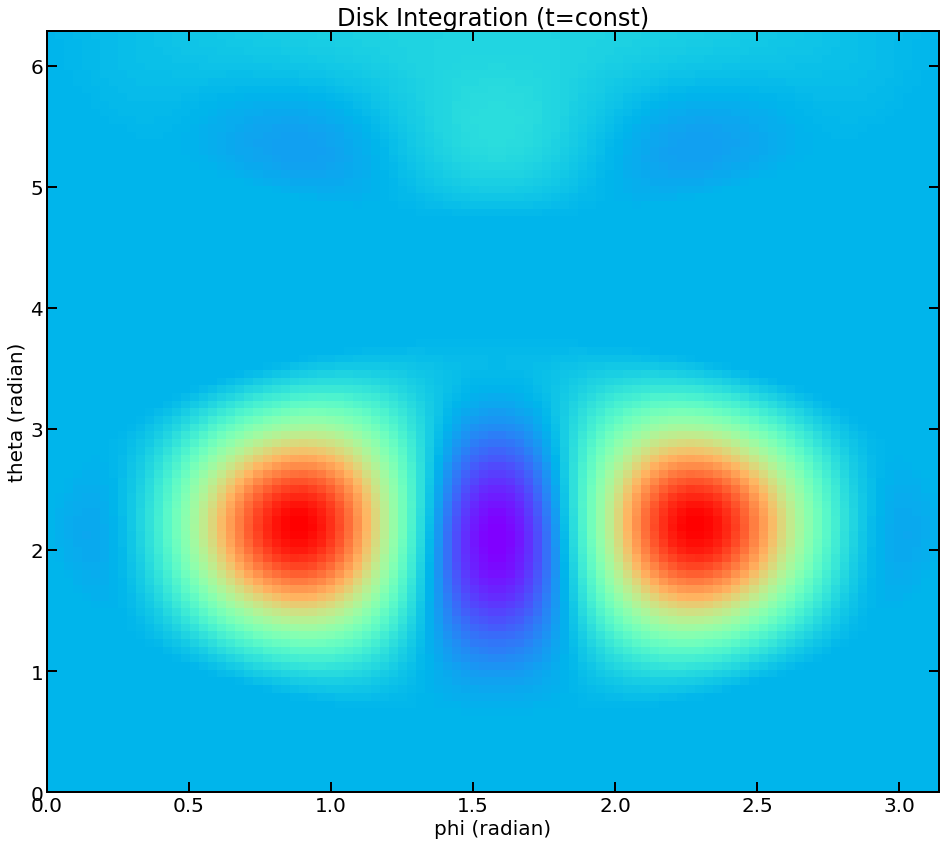

In [28]:
cmap = plt.get_cmap('rainbow')
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
fig=plt.figure(figsize=(16,14)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', which='major', bottom=True, top=True, left=True, right=True, length=10,\
               width=2)
ax.tick_params(direction='in', which='minor', bottom=True, top=True, left=True, right=True, length=4,\
               width=2)


ax.set_xlabel('phi (radian)')
ax.set_ylabel('theta (radian)')
ax.set_title('Disk Integration (t=const)')

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

im=ax.pcolormesh(phi,theta,t_sph[:,:,4].T,cmap=cmap)

fig.show()

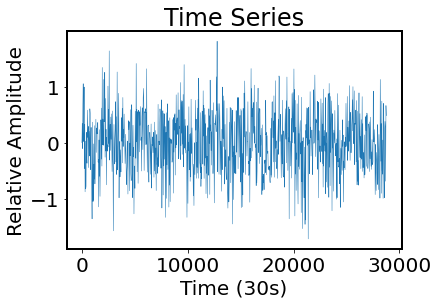

In [27]:
plt.plot(time,t_sph[75,50,:],linewidth=0.5)
plt.title('Time Series')
plt.xlabel('Time (30s)')
plt.ylabel('Relative Amplitude')
plt.show()

In [29]:
np.save('timeseries.npy',t_sph)

In [21]:
test = np.load('timeseries.npy')